**<center><span style="font-size: 30px;"> Сборный проект № 2</span></center>**

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных-перед-анализом" data-toc-modified-id="Подготовка-данных-перед-анализом-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных перед анализом</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек-для-работы-с-инструментами-кода" data-toc-modified-id="Импорт-библиотек-для-работы-с-инструментами-кода-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек для работы с инструментами кода</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Изучение-варонки-событий" data-toc-modified-id="Изучение-варонки-событий-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Изучение варонки событий</a></span><ul class="toc-item"><li><span><a href="#Ознакомление-с-событиями" data-toc-modified-id="Ознакомление-с-событиями-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Ознакомление с событиями</a></span></li><li><span><a href="#Расчет-воронки-событий" data-toc-modified-id="Расчет-воронки-событий-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Расчет воронки событий</a></span></li></ul></li><li><span><a href="#Изучение-результатов-теста" data-toc-modified-id="Изучение-результатов-теста-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Изучение результатов теста</a></span><ul class="toc-item"><li><span><a href="#Проверка-корректности-проведения-теста" data-toc-modified-id="Проверка-корректности-проведения-теста-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Проверка корректности проведения теста</a></span></li><li><span><a href="#Расчет-статистической-разницы-между-долями-пользователей" data-toc-modified-id="Расчет-статистической-разницы-между-долями-пользователей-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Расчет статистической разницы между долями пользователей</a></span></li></ul></li><li><span><a href="#Заключение" data-toc-modified-id="Заключение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Заключение</a></span></li></ul></div>

# Техническое задание

<div class="alert alert-secondary" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
    

**Цель проекта** - изучение поведений пользователей мобильного приложения для стартапа, продающего продукты питания. 
    
В ходе исследования необходимо выполнить следующие **задачи**:
    
- [загрузить и подготовить данные перед анализам](#dwn);
- [изучить данные](#observe);
- [изучить воронку событий](#voronka);
- [изучить результаты А/А/В-теста](#test).
 
Чтобы сделать [заключение](#conclusion):
    
    
- узнаем, как пользователи доходят до покупки: сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно;
- исследуем результаты A/A/B-эксперимента: выясним, как изменение шрифта отразится на конверсии пользователей.   
  
    
</div>

## Подготовка данных перед анализом
<a id='dwn'></a>

### Импорт библиотек для работы с инструментами кода

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
from scipy.stats import binom, norm
import math as mth
from math import sqrt
import warnings
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
import scipy.stats as stats
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters() 

### Загрузка данных

Каждая запись в логе — это действие пользователя, или событие. 

In [2]:
data = pd.read_csv('/Users/anastasia/Downloads/logs_exp.csv', sep='\t')

<u>Вывод первых пяти строк</u>

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Предобработка данных

<u>Изменение названий столбцов</u>

In [4]:
data.columns = data.columns.str.lower()

In [5]:
data = data.rename(columns={
    'eventname':'event_name', 'deviceidhash':'user_id', 'eventtimestamp':'event_timestamp', 
    'expid':'exp_id'
})

<u>Вывод основной информации</u>

In [6]:
def data_info(df, name=''):
    print(f'{name}')
    print (f'Основная информация:')
    print('-'*50)
    print (df.info())
    print('-'*50)
    print('Пропуски в столбцах:')
    print('-'*50)
    print(df.isna().sum())
    print('-'*50)
    if df.duplicated().sum() > 0:
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')

In [7]:
data_info(data)


Основная информация:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   user_id          244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
--------------------------------------------------
Пропуски в столбцах:
--------------------------------------------------
event_name         0
user_id            0
event_timestamp    0
exp_id             0
dtype: int64
--------------------------------------------------
Дубликатов:  413


Нужно поменять тип данных в столбце с временем события и удалить дубликаты. Пропуски в данных отсутствуют.

<u>Обработка дубликатов</u>

In [8]:
data = data.drop_duplicates()

Посмотрим на неявные дубликаты.

In [9]:
columns = ['event_name', 'exp_id']

for column in columns:
    print('')
    print(column, data[column].unique())


event_name ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']

exp_id [246 248 247]


Все в норме.

<u>Изменение типа данных</u>

Добавим новые столбцы - с датой и временеми и просто с датой.

In [10]:
data['date_time'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['date'] = data['date_time'].astype('datetime64[D]')

<u>Проверка</u>

In [11]:
data_info(data)


Основная информация:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB
None
--------------------------------------------------
Пропуски в столбцах:
--------------------------------------------------
event_name         0
user_id            0
event_timestamp    0
exp_id             0
date_time          0
date               0
dtype: int64
------------------------------------------------

**Вывод:** в результате проделанной работы были загружены данные с событиями в приложении, произведена обработка пропусков, удалены дубликаты, изменены названия столбцов, добавлены столбцы с датой и временем.

## Изучение данных
<a id='observe'></a>

Сколько всего событий в логе? Посмотрим, какие события есть и сколько пользователей совершали то или иное действие.

In [12]:
print('Уникальных событий в логе:', data['event_name'].nunique())
print()
print('Количество каждого события:\n',data['event_name'].value_counts())
print()
print('Число пользователей по событиям:\n', data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False))

Уникальных событий в логе: 5

Количество каждого события:
 MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Число пользователей по событиям:
 event_name
MainScreenAppear           7439
OffersScreenAppear         4613
CartScreenAppear           3749
PaymentScreenSuccessful    3547
Tutorial                    847
Name: user_id, dtype: int64


Сколько всего пользователей в логе?

In [13]:
print('Пользователей в логе:', data['user_id'].nunique())

Пользователей в логе: 7551


Сколько в среднем событий приходится на пользователя?

In [14]:
print('В среднем на пользователя приходится {} события'.format(
    round(data['event_name'].count()/data['user_id'].nunique(), 3)))

В среднем на пользователя приходится 32.276 события


Данными за какой период предоставлены? Найдем максимальную и минимальную дату. Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросьте более старые. Данными за какой период времени мы располагаем на самом деле?

Изучим период, за который предоставлены данные.

In [15]:
print('Данные предоставлены за {} дней'.format((data['date'].max() - data['date'].min()).days+1))
print('Максимальная дата:', data['date'].max())
print('Минимальная дата:', data['date'].min())

Данные предоставлены за 14 дней
Максимальная дата: 2019-08-07 00:00:00
Минимальная дата: 2019-07-25 00:00:00


Построим столбчатую диаграмму.

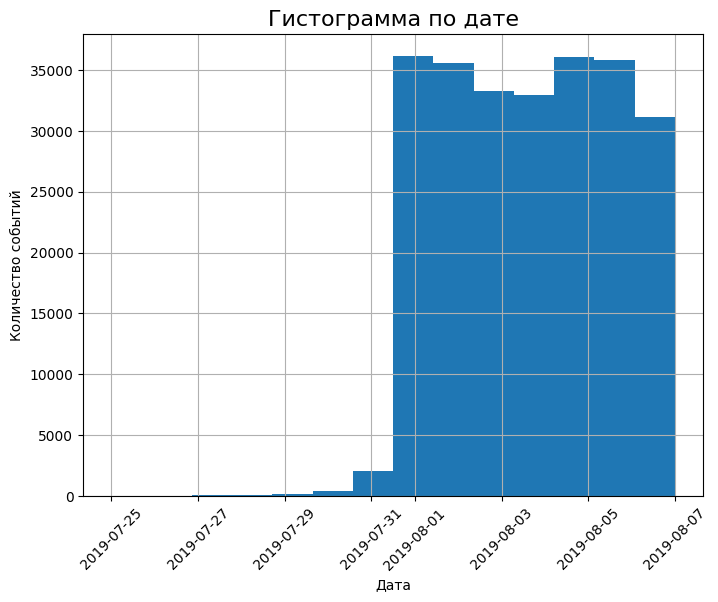

In [16]:
plt.figure(figsize=(8,6))
data['date'].hist(bins=data['date'].nunique(), grid=True)
plt.title('Гистограмма по дате', fontsize=16)
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Количество событий')
plt.show()

По гистограмме заметно, что событий ранее 31 мая 2019 значительно меньше. Отбросим из-за неполноты данных.

In [17]:
data2 = data.query('date > "2019-07-31"').reset_index()

In [18]:
print('Данные анализируются за {} дней'.format((data2['date'].max() - data2['date'].min()).days+1))

Данные анализируются за 7 дней


Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [19]:
print('Количество потерянных событий:', data['date'].count()-data2['date'].count())
print('Процент потерянных событий: {:.2%}'.format((data['date'].count()-data2['date'].count())/data['date'].count()))

Количество потерянных событий: 2826
Процент потерянных событий: 1.16%


In [20]:
print('Количество потерянных пользователей:', data['user_id'].nunique()-data2['user_id'].nunique())
print('Процент потерянных пользователей: {:.2%}'.format((data['user_id'].nunique()-data2['user_id'].nunique())/data['user_id'].nunique()))

Количество потерянных пользователей: 17
Процент потерянных пользователей: 0.23%


Как видно, потерянных данных немного для актуального анализа.

Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [21]:
data2.groupby('exp_id')['user_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Корректность проведения А/В-теста проверим позже.

## Изучение варонки событий
<a id='voronka'></a>

### Ознакомление с событиями

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [22]:
data2['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Итак, в датафрейме отслеживаются следующие события:
- main screen appear - появился главный экран
- offer's screen appear - появился экран с предложениями
- cart screen apear - появился экран с корзиной
- payment screen successful - платеж успешно выполнен
- tutorial -  обучение

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [23]:
voronka = data2.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
voronka['conversion'] = (voronka['user_id'] / data2['user_id'].nunique() * 100).round(1)
print('Количество и процент пользователей совершивших событие:')
voronka.style.hide_index()

Количество и процент пользователей совершивших событие:


event_name,user_id,conversion
MainScreenAppear,7419,98.500000
OffersScreenAppear,4593,61.000000
CartScreenAppear,3734,49.600000
PaymentScreenSuccessful,3539,47.000000
Tutorial,840,11.100000


Предположим, в каком порядке происходят события. Выстроим их в логическую последовательность действий пользователя.

События выстраиваются в следующую цепочку:
- main screen appear
-  *tutorial*
- offers screen appear
- cart screen appear
- payment screen successful

Обучение прошло около 11% пользователей, можно сделать вывод, что вводную часть можно пропуспустить, а значит событие `tutorial` не выстраивается в последовательную цепочку, не будем учитывать при расчете воронки.

In [24]:
voronka = voronka.query('event_name != "Tutorial"')

In [25]:
fig = px.funnel(voronka, y='event_name', x='conversion')
fig.update_layout(title={
    'text': 'Воронка',
    'font': {'size': 20},
    'x': 0.5 # размещение по центру
}) 
fig.update_yaxes = 'Событие'
fig.show()

### Расчет воронки событий

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Изучим пошаговую конверсию.

In [26]:
warnings.filterwarnings("ignore")
voronka['step_conversion'] = 0
for i in range(0, len(voronka['conversion'])):
    if i == 0:
        voronka['step_conversion'].iloc[i] = 100
    else:
        voronka['step_conversion'].iloc[i] = round(voronka['user_id'].iloc[i] / voronka['user_id'].iloc[i-1], 1)*100
display(voronka.style.hide_index())

event_name,user_id,conversion,step_conversion
MainScreenAppear,7419,98.500000,100.000000
OffersScreenAppear,4593,61.000000,60.000000
CartScreenAppear,3734,49.600000,80.000000
PaymentScreenSuccessful,3539,47.000000,90.000000


80% пользователей после ознакомления с продукцией переходят к формированию корзины. 90% пользователей, добавивших товар в козину, завершают его оплатой.

Больше всего теряется на втором этапе: 40% пользователей не приступают к изучению асортимента после открытия главного экрана. До оплаты доходят 47% пользователей после открытия главного экрана.

**Вывод:** изучена воронка событий, определена последовательная цепочка отслеживаемых действий пользователя - переход от главного экрана до успешной оплаты корзины. Выяснено, что 53% клиентов не доходят до оплаты корзины после первого этапа, основная часть (около 40%) теряется после первого этапа при переходе к экрану с предложениями.

## Изучение результатов теста
<a id='test'></a>

Исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

### Проверка корректности проведения теста

Посмотрим, сколько пользователей в каждой экспериментальной группе.

In [27]:
data2.groupby('exp_id')['user_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Проверим, есть ли пересечния между пользователями в разных группах.

In [28]:
# разделяем заказы по группам
group_a1 = data2.query('exp_id == 246')
group_a2 = data2.query('exp_id == 247')
group_b = data2.query('exp_id == 248')

# получаем id пользователей, попавших в обе группы 
common_users_aa = set(group_a1['user_id']) & set(group_a2['user_id'])
common_users_a1b = set(group_a1['user_id']) & set(group_b['user_id'])
common_users_a2b = set(group_a2['user_id']) & set(group_b['user_id'])


print('Количество общих пользователей между А/А-группами: {}\n'
      'Количество общих пользователей между А1/В-группами: {}\n'
      'Количество общих пользователей между А2/В-группами: {}'.format(len(common_users_aa), len(common_users_a1b), len(common_users_a2b)))

Количество общих пользователей между А/А-группами: 0
Количество общих пользователей между А1/В-группами: 0
Количество общих пользователей между А2/В-группами: 0


Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

**Нулевая гипотеза:** разница между группами для А/А-эксперимента отсутствует. **Альтернативная гипотеза:** разница между группами для А/А-эксперимента существенна. Разница между пропорциями, наблюдаемыми на выборках, будет распределена нормально

In [29]:
alpha = 0.05  # критический уровень статистической значимости

users_1 = group_a1['user_id'].nunique() # число пользователей в 246 группе
users_2 = group_a2['user_id'].nunique() # число пользователей в 247 группе
total_1 = group_a1['user_id'].count() # число событий в 246 группе
total_2 = group_a2['user_id'].count() # число событий в 247 группе

p1 = users_1/total_1 
p2 = users_2/total_2

p_combined = (users_1 + users_2) / (total_1 + total_2)
difference = p1 - p2
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_1 + 1/users_2)) 

distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2 

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными'
    )

p-значение:  0.7933578138021369
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


### Расчет статистической разницы между долями пользователей

<u>Подготовка данных перед Z-тестом</u>

Напишем функцию для проведения Z-теста. Сначала создадим датафрейм с разделением пользователей на группы и события, добавим 249 группу - объединяющую пользователей из 246 и 247 групп. Исключим событие `Tutorial`, так как оно не отражает изменения в поведении пользователей из-за изменения дизайна и в их покупательских привычках.  

In [30]:
# создадим датафрейм с числом уникальных пользователей по событиям и контрольным группам
users_events = data2.query('event_name != "Tutorial"').pivot_table(index='exp_id',columns = 'event_name', values='user_id',aggfunc='nunique')
users_events['users_total'] = data2.groupby('exp_id')['user_id'].nunique()
users_events.loc[249] = users_events.loc[246] + users_events.loc[247]
display(users_events)

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,users_total
exp_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537
249,2504,4926,3062,2358,4997


**Нулевая гипотеза:** разница между долями пользователей в группах отсутвует. **Альтернативная гипотеза:** разница между долями пользователей в группах существенна.

Нам предстоит «множетсвенное тестирование»: нужно провести несколько параллельных стат-тестов на одном и том же наборе данных. Для уменьшения FWER (от англ. family-wise error rate, «групповой коэффициент ошибок») скорректируем уровнь статистической значимости (`alpha`). Так как всего предстоит совершить 16 стат-тестов, применим метод Холма, дающие более высокие значения мощности теста, что снижает вероятность допущения ошибки II рода.

In [31]:
# напишем функцию для Z-теста

def z_test(group_1, group_2, event, alpha, i): 
    
    event_1 = users_events.loc[group_1, event]
    event_2 = users_events.loc[group_2, event] 
    
    users_1 = users_events.loc[group_1, 'users_total'] 
    users_2 = users_events.loc[group_2, 'users_total'] 
    
    p1 = event_1 / users_1 
    p2 = event_2 / users_2 
    
    difference = p1 - p2
    p_combined = (event_1 + event_2) / (users_1 + users_2) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / users_1 + 1 / users_2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    m = 16
    if i != m:
        alpha_holm = alpha / (m - i)
    else:
        alpha_holm = alpha
     
    print('Проверка для групп {} и {}, событие: {}, p-значение: {:.2%}'.format(group_1, group_2, event, p_value))
    
    if (p_value < alpha_holm):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными')
        

<u>Сравнение А/А-групп по событиям</u>

In [32]:
i = 0
for event in data2.query('event_name != "Tutorial"')['event_name'].unique():
    i += 1
    print(i)
    print('-'*80)
    z_test(246, 247, event, 0.05, i)
    print('')

1
--------------------------------------------------------------------------------
Проверка для групп 246 и 247, событие: MainScreenAppear, p-значение: 75.71%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

2
--------------------------------------------------------------------------------
Проверка для групп 246 и 247, событие: OffersScreenAppear, p-значение: 24.81%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

3
--------------------------------------------------------------------------------
Проверка для групп 246 и 247, событие: CartScreenAppear, p-значение: 22.88%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

4
--------------------------------------------------------------------------------
Проверка для групп 246 и 247, событие: PaymentScreenSuccessful, p-значение: 11.46%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Как видно, статистичекой разницы между долями пользователй нет между группами А/А теста. Это говорит, что тест проведен корректно, нужно отметить, что при уровне статистической разницы в 10% результат был бы тот же.

<u>Сравнение А/В-групп по событиям</u>

In [33]:
for event in data2.query('event_name != "Tutorial"')['event_name'].unique():
    i += 1
    print(i)
    print('-'*80)
    z_test(246, 248, event, 0.05, i)
    print('')     

5
--------------------------------------------------------------------------------
Проверка для групп 246 и 248, событие: MainScreenAppear, p-значение: 29.50%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

6
--------------------------------------------------------------------------------
Проверка для групп 246 и 248, событие: OffersScreenAppear, p-значение: 20.84%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

7
--------------------------------------------------------------------------------
Проверка для групп 246 и 248, событие: CartScreenAppear, p-значение: 7.84%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

8
--------------------------------------------------------------------------------
Проверка для групп 246 и 248, событие: PaymentScreenSuccessful, p-значение: 21.23%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



In [34]:
for event in data2.query('event_name != "Tutorial"')['event_name'].unique():
    i += 1
    print(i)
    print('-'*80)
    z_test(247, 248, event, 0.05, i)
    print('')

9
--------------------------------------------------------------------------------
Проверка для групп 247 и 248, событие: MainScreenAppear, p-значение: 45.87%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

10
--------------------------------------------------------------------------------
Проверка для групп 247 и 248, событие: OffersScreenAppear, p-значение: 91.98%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

11
--------------------------------------------------------------------------------
Проверка для групп 247 и 248, событие: CartScreenAppear, p-значение: 57.86%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

12
--------------------------------------------------------------------------------
Проверка для групп 247 и 248, событие: PaymentScreenSuccessful, p-значение: 73.73%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Как видно, изменение шрифта в приложении не отразилось на поведении пользователей: статистической разницы нет.

<u>Сравнение объединенной контрольной группы и В-группы по событиям</u>

In [35]:
for event in data2.query('event_name != "Tutorial"')['event_name'].unique():
    i += 1
    print(i)
    print('-'*80)
    z_test(249, 248, event, 0.05, i)
    print('')

13
--------------------------------------------------------------------------------
Проверка для групп 249 и 248, событие: MainScreenAppear, p-значение: 29.42%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

14
--------------------------------------------------------------------------------
Проверка для групп 249 и 248, событие: OffersScreenAppear, p-значение: 43.43%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

15
--------------------------------------------------------------------------------
Проверка для групп 249 и 248, событие: CartScreenAppear, p-значение: 18.18%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

16
--------------------------------------------------------------------------------
Проверка для групп 249 и 248, событие: PaymentScreenSuccessful, p-значение: 60.04%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Как и ожидалось, статистическая разница между долями пользователей так же отсутствует.

**Вывод:** были посчитаны пользователи в каждой группе: в группе 246 - 2484 пользователей, в группе 247 - 2513, в группе 248 - 2537. Проверена корректность проведения теста: пересечения между пользователями групп отсутствует, статистической разницы между долями пользователей и событий двух контрольных групп (246 и 247) А/А-теста нет. Назначен критический уровень статистической значимости в 5%, что означает, что мы готовы допустить вероятность ошибки в 5%. Этот уровень позволяет получить более надежные результаты и уменьшить вероятность ложных выводов. При использовании уровня значимости в 10% (`alpha` = 0,1) возрастает вероятность ложных выводов и ошибочных интерпретаций результатов исследования, в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна (ошибка I рода), поэтому в данном исследовании назначаем более оптимальный вариант - `alpha` = 0,05. Всего было проведено 16 статистических проверок, включая проверки теста на соблюдение правил проведения. При «множественном тестировании» возникает риск возникновения FWER, т.е. вероятность допустить ошибку I рода (ошибочно отвергнуть нулевую гипотезу) «накапливается» с каждым тестом. Для этого мы приняли поправку Холма для корректировки критического уровня статистической значимости. Результаты показали, что статистической разницы между А/А/В-группами нет: пользователи так же пользуются приложением и покупают продукты питания, как и до изменения шрифта. 

## Заключение 
<a id='conclusion'></a>

<div class="alert alert-secondary" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
    
В ходе работы была произведена преобработка данных: приведены заголовки к единому регистру, обработаны дубликаты и пропуски, изменены типы данных. Изучены данные перед анализом: всего **7551** данных в логе, данные предоставлены с 25 мая по 7 июня 2019 года. Из-за неполноты данных за этот период было принято решение рассматривать события за **1 - 7 августа 2019 года**.
    
Всего 5 событий, которые выстраиваются в следующую логическую цепочку: пользователь перешел на главный экран, обучение пользователя, появился экран с предложениями, появился экран с корзиной, платеж успешно выполнен. Для изучения воронки событие с вводным уроком не рассматривается, так как это необязательный этап и только 11% пользователей проходят обучение. В результате получены следующие **сведения**:
    
- больше всего теряется на этапе ознакомления с асортиментом магазина: 40% пользователей не приступают к изучению продукции после открытия главного экрана;
- до оплаты доходят 47% пользователей после открытия главного экрана.

На основе исследования результатов А/А/В-теста сделаны следующие **выводы**:

- тест проведен коррректно: пересечения между пользователями групп отсутствуют, статистической разницы между долями пользователей контрольных групп нет;
- при уровне статистической значимости в 5% **статистической разницы между контрольными группами и проверяемой нет: изменение шрифта не повлекло за собой изменение конверсии** пользователей на всех этапах исследования (от перехода на главный экран до совершения платежа).
    
</div>    